In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy
import string
import warnings
import pickle
from pgmpy.models import BayesianModel
from pgmpy.models import DynamicBayesianNetwork as DBN
from pgmpy.estimators import BayesianEstimator
from pgmpy.estimators import HillClimbSearch,BicScore
import networkx as nx

### function - get body part location for each pair of cameras

In [2]:
def body_part_locs_eachpair(cameraAB_h5_data):
    # clean the data first
    ncols = cameraAB_h5_data.shape[1]
    nframes = cameraAB_h5_data.shape[0]
    animal_names = []
    body_parts = []
    xyz_axis = []

    for i in np.arange(0,ncols,1):
        animal_names.append(cameraAB_h5_data.columns[i][1])
        body_parts.append(cameraAB_h5_data.columns[i][2])
        xyz_axis.append(cameraAB_h5_data.columns[i][3])
  
        # fill in the nan data point
        data_point = cameraAB_h5_data.iloc[:,i]
        # data_point_filled = data_point.interpolate(method='nearest',limit_direction='both')
        # data_point_filled = data_point_filled.interpolate(method='linear',limit_direction='both')
        data_point_filled = data_point
        
        # remove outlier
        q1 = np.nanquantile(data_point_filled,0.25)
        q3 = np.nanquantile(data_point_filled,0.75)
        thres1 = q1 - 1.5*abs(q3-q1)
        thres2 = q3 + 1.5*abs(q3-q1)
        ind = (data_point_filled>thres2) | (data_point_filled<thres1)
        data_point_filled[ind] = np.nan
        # data_point_filled = data_point_filled.interpolate(method='nearest',limit_direction='both')
        
        # smooth the data point   
        # data_point_filtered = data_point_filled.rolling(window=5, win_type='gaussian', center=True).mean(std=0.5)
        #
        cameraAB_h5_data.iloc[:,i] = data_point_filled
    
    animal_names_unique = pd.unique(animal_names)
    body_parts_unique = pd.unique(body_parts)
    xyz_axis_unique = pd.unique(xyz_axis)

    #
    # find the location of each body part
    body_part_locs = {}
    for iname in animal_names_unique:
        for ibody in body_parts_unique:
            ind = np.isin(animal_names,iname) & np.isin(body_parts,ibody)
            body_part_locs[(iname,ibody)] = cameraAB_h5_data.iloc[:,ind]            
            
    return body_part_locs

### function - align the two cameras

In [3]:
def camera_align(body_part_locs_camera23, body_part_locs_camera12):
# try the rotation on all possible pairs
    animal_names_unique = pd.unique(pd.DataFrame(body_part_locs_camera23.keys()).iloc[:,0])
    body_parts_unique = pd.unique(pd.DataFrame(body_part_locs_camera23.keys()).iloc[:,1])
    
    RR_sum = {}
    tt_sum = {}
    err_sum = {}
    for iname in animal_names_unique:
        for ibody in body_parts_unique:
            xxx = body_part_locs_camera23[(iname,ibody)]
            yyy = body_part_locs_camera12[(iname,ibody)]
            min_length = np.min([xxx.shape[0],yyy.shape[0]])
        
            xxx = xxx.loc[np.arange(0,min_length,1),:]
            yyy = yyy.loc[np.arange(0,min_length,1),:]     
        
            ind_good = (~np.isnan(xxx.iloc[:,0]) & ~np.isnan(xxx.iloc[:,1]) & ~np.isnan(xxx.iloc[:,2])) & (~np.isnan(yyy.iloc[:,0]) & ~np.isnan(yyy.iloc[:,1]) & ~np.isnan(yyy.iloc[:,2])) 
            xxx_values = pd.DataFrame.transpose(xxx.loc[ind_good,:]).values
            yyy_values = pd.DataFrame.transpose(yyy.loc[ind_good,:]).values
        
            xxx_centroid = np.dot(np.mean(xxx_values,axis = 1).reshape(3,1), np.ones((1,np.shape(xxx_values)[1])))
            yyy_centroid = np.dot(np.mean(yyy_values,axis = 1).reshape(3,1), np.ones((1,np.shape(xxx_values)[1])))
            HH = np.dot((xxx_values - xxx_centroid), np.transpose(yyy_values - yyy_centroid))
            u, s, vh = np.linalg.svd(HH, full_matrices=True)
            RR = np.dot(np.transpose(vh),np.transpose(u))
            tt= yyy_centroid - np.dot(RR,xxx_centroid)
            tt = tt[:,1].reshape(3,1)
        
            RR_sum[(iname,ibody)] = RR
            tt_sum[(iname,ibody)] = tt
            err_sum[(iname,ibody)] = np.sum(np.square(yyy_values - (np.dot(RR,xxx_values)+np.dot(tt, np.ones((1,np.shape(xxx_values)[1]))))))
    
    return RR_sum, tt_sum, err_sum

### function - merge the two pairs of cameras

In [4]:
def camera_merge(body_part_locs_camera23, body_part_locs_camera12, RR_sum, tt_sum, err_sum):
# merge the two pairs of cameras
    animal_names_unique = pd.unique(pd.DataFrame(body_part_locs_camera23.keys()).iloc[:,0])
    body_parts_unique = pd.unique(pd.DataFrame(body_part_locs_camera23.keys()).iloc[:,1])
    
    body_part_locs_merge = {}
    for iname in animal_names_unique:
        for ibody in body_parts_unique:
            xxx = body_part_locs_camera23[(iname,ibody)]
            yyy = body_part_locs_camera12[(iname,ibody)]
            min_length = np.min([xxx.shape[0],yyy.shape[0]])
            
            ## transpose the two pair of cameras
        
            # RR = RR_sum[min(err_sum, key=err_sum.get)]
            # tt = tt_sum[min(err_sum, key=err_sum.get)]
            RR = RR_sum[(iname,ibody)]
            tt = tt_sum[(iname,ibody)]
            body_part_x = np.transpose(xxx.loc[np.arange(0,min_length,1),:])
            body_part_project = np.transpose(np.dot(RR,body_part_x) + np.dot(tt, np.ones((1,np.shape(body_part_x)[1]))))
            body_part_origin = yyy.loc[np.arange(0,min_length,1),:].values
            body_part_origin[np.sum(np.isnan(body_part_origin),axis=1)>0,:] = body_part_project[np.sum(np.isnan(body_part_origin),axis=1)>0,:]
            #
            # body_part_locs_merge[(iname,ibody)] = body_part_origin
    
            ## average across the two pair of cameras
            body_part_locs_merge[(iname,ibody)] = pd.concat([xxx, yyy]).groupby(level=0).mean()
            
                       
    
    return body_part_locs_merge

### function - make demo videos for the body part tracking

In [5]:
def tracking_video_demo(camera23_analyzed_path, body_part_locs, nframes):

    import matplotlib.animation as animation

    # Settings
    video_file = camera23_analyzed_path + "camera12_23_merged_tracking_demo.mp4"
    clear_frames = True     # Should it clear the figure between each frame?
    fps = 30

    # Output video writer
    FFMpegWriter = animation.writers['ffmpeg']
    metadata = dict(title='Animal tracking demo', artist='Matplotlib', comment='')
    writer = FFMpegWriter(fps=fps, metadata=metadata)

    animal_names_unique = pd.unique(pd.DataFrame(body_part_locs.keys()).iloc[:,0])
    body_parts_unique = pd.unique(pd.DataFrame(body_part_locs.keys()).iloc[:,1])
    nanimals = np.shape(animal_names_unique)[0]  
    nbodyparts = np.shape(body_parts_unique)[0]

    # axislim = [np.nanmin(list(body_part_locs.values())), np.nanmax(list(body_part_locs.values()))]
    axislim = [-10,10]
    
    fig = plt.figure(figsize = (5,5))
    ax = plt.axes(projection='3d')
    ax.set_xlim(axislim)
    ax.set_ylim(axislim)
    ax.set_zlim(axislim)
    
    with writer.saving(fig, video_file, 100):
        for iframe in np.arange(0,nframes,1):    
            if clear_frames:
                fig.clear()
                ax = plt.axes(projection='3d')
                ax.set_xlim(axislim)
                ax.set_ylim(axislim)
                ax.set_zlim(axislim)
            
            for ianimal_name in animal_names_unique:    
                bodypart_loc_iframe = np.zeros((nbodyparts,3))
        
                for ibdpart in np.arange(0,nbodyparts,1):           

                    ibdpart_name = body_parts_unique[ibdpart]
                    bodypart_loc_iframe[ibdpart,:] = np.array(body_part_locs[(ianimal_name,ibdpart_name)])[iframe,:]
            
                # plot the body parts
                ax.plot3D(bodypart_loc_iframe[:,0], bodypart_loc_iframe[:,1], bodypart_loc_iframe[:,2],'.')
            writer.grab_frame()

### function - find social gaze time point

In [6]:
def find_socialgaze_timepoint(body_part_locs_camera23, body_part_locs_camera12, body_part_locs_merge, angle_thres):
    
    animal_names_unique = pd.unique(pd.DataFrame(body_part_locs_camera23.keys()).iloc[:,0])
    body_parts_unique = pd.unique(pd.DataFrame(body_part_locs_camera23.keys()).iloc[:,1])
    min_length = np.min([list(body_part_locs_camera23.values())[0].shape[0],list(body_part_locs_camera12.values())[0].shape[0]])

    warnings.filterwarnings('ignore')
    eye_direction_merge = {}
    eye_contact_or_not_merge = {}
    look_at_face_or_not_merge = {}
    
    for iname in animal_names_unique:
        eye_dir_frames = []
        eye_contact_frames = []
        look_at_face_frames = []
        
        for iframe in np.arange(0,min_length,1):
            lefteye_loc = np.array(body_part_locs_merge[(iname,'leftEye')])[iframe,:]
            righteye_loc = np.array(body_part_locs_merge[(iname,'rightEye')])[iframe,:]
            lefttuft_loc = np.array(body_part_locs_merge[(iname,'leftTuft')])[iframe,:]
            righttuft_loc = np.array(body_part_locs_merge[(iname,'rightTuft')])[iframe,:]
            whiblz_loc = np.array(body_part_locs_merge[(iname,'whiteBlaze')])[iframe,:]
            mouth_loc = np.array(body_part_locs_merge[(iname,'mouth')])[iframe,:]
        
            Vect1 = lefteye_loc - righteye_loc
            Vect2 = whiblz_loc - mouth_loc
            Vect3 = lefttuft_loc - lefteye_loc
            Vect4 = righttuft_loc - righteye_loc
        
            try:       
                Vect1 = Vect1 / scipy.linalg.norm(Vect1)
                Vect2 = Vect2 / scipy.linalg.norm(Vect2) 
            except:
                Vect1 = Vect1
                Vect2 = Vect2
            eyesight_dir = np.cross(Vect1, Vect2)
        
            if ((np.dot(eyesight_dir, Vect3)>0) | (np.dot(eyesight_dir, Vect4)>0)):
                eyesight_dir = -eyesight_dir
        
            eye_dir_frames.append(eyesight_dir)      
        
            # examine whether this animal is looking at the other's eyes or face
            if (iname == animal_names_unique[0]): 
                iname_other = animal_names_unique[1]
            elif (iname == animal_names_unique[1]): 
                iname_other = animal_names_unique[0]
            
            lefteye_loc_other = np.array(body_part_locs_merge[(iname_other,'leftEye')])[iframe,:]
            righteye_loc_other = np.array(body_part_locs_merge[(iname_other,'rightEye')])[iframe,:]
            lefttuft_loc_other = np.array(body_part_locs_merge[(iname_other,'leftTuft')])[iframe,:]
            righttuft_loc_other = np.array(body_part_locs_merge[(iname_other,'rightTuft')])[iframe,:]
            whiblz_loc_other = np.array(body_part_locs_merge[(iname_other,'whiteBlaze')])[iframe,:]
            mouth_loc_other = np.array(body_part_locs_merge[(iname_other,'mouth')])[iframe,:]
        
            # where left eye is looking
            # vector between body part
            vect1_lefteye = lefteye_loc_other - lefteye_loc
            vect2_lefteye = righteye_loc_other - lefteye_loc
            vect3_lefteye = lefttuft_loc_other - lefteye_loc
            vect4_lefteye = righttuft_loc_other - lefteye_loc
            vect5_lefteye = whiblz_loc_other - lefteye_loc
            vect6_lefteye = mouth_loc_other - lefteye_loc
            # angle between body part vector and eyesight direction
            angle1_lefteye =  np.sign(np.dot(eyesight_dir,vect1_lefteye))*np.arccos(np.clip(np.dot(eyesight_dir/np.linalg.norm(eyesight_dir), vect1_lefteye/np.linalg.norm(vect1_lefteye)), -1.0, 1.0))       
            angle2_lefteye =  np.sign(np.dot(eyesight_dir,vect2_lefteye))*np.arccos(np.clip(np.dot(eyesight_dir/np.linalg.norm(eyesight_dir), vect2_lefteye/np.linalg.norm(vect2_lefteye)), -1.0, 1.0))
            angle3_lefteye =  np.sign(np.dot(eyesight_dir,vect3_lefteye))*np.arccos(np.clip(np.dot(eyesight_dir/np.linalg.norm(eyesight_dir), vect3_lefteye/np.linalg.norm(vect3_lefteye)), -1.0, 1.0))
            angle4_lefteye =  np.sign(np.dot(eyesight_dir,vect4_lefteye))*np.arccos(np.clip(np.dot(eyesight_dir/np.linalg.norm(eyesight_dir), vect4_lefteye/np.linalg.norm(vect4_lefteye)), -1.0, 1.0))
            angle5_lefteye =  np.sign(np.dot(eyesight_dir,vect5_lefteye))*np.arccos(np.clip(np.dot(eyesight_dir/np.linalg.norm(eyesight_dir), vect5_lefteye/np.linalg.norm(vect5_lefteye)), -1.0, 1.0))
            angle6_lefteye =  np.sign(np.dot(eyesight_dir,vect6_lefteye))*np.arccos(np.clip(np.dot(eyesight_dir/np.linalg.norm(eyesight_dir), vect6_lefteye/np.linalg.norm(vect6_lefteye)), -1.0, 1.0))
        
            # where right eye is looking
            # vector between body part
            vect1_righteye = lefteye_loc_other - righteye_loc
            vect2_righteye = righteye_loc_other - righteye_loc
            vect3_righteye = lefttuft_loc_other - righteye_loc
            vect4_righteye = righttuft_loc_other - righteye_loc
            vect5_righteye = whiblz_loc_other - righteye_loc
            vect6_righteye = mouth_loc_other - righteye_loc
            # angle between body part vector and eyesight direction
            angle1_righteye =  np.sign(np.dot(eyesight_dir,vect1_righteye))*np.arccos(np.clip(np.dot(eyesight_dir/np.linalg.norm(eyesight_dir), vect1_righteye/np.linalg.norm(vect1_righteye)), -1.0, 1.0))       
            angle2_righteye =  np.sign(np.dot(eyesight_dir,vect2_righteye))*np.arccos(np.clip(np.dot(eyesight_dir/np.linalg.norm(eyesight_dir), vect2_righteye/np.linalg.norm(vect2_righteye)), -1.0, 1.0))
            angle3_righteye =  np.sign(np.dot(eyesight_dir,vect3_righteye))*np.arccos(np.clip(np.dot(eyesight_dir/np.linalg.norm(eyesight_dir), vect3_righteye/np.linalg.norm(vect3_righteye)), -1.0, 1.0))
            angle4_righteye =  np.sign(np.dot(eyesight_dir,vect4_righteye))*np.arccos(np.clip(np.dot(eyesight_dir/np.linalg.norm(eyesight_dir), vect4_righteye/np.linalg.norm(vect4_righteye)), -1.0, 1.0))
            angle5_righteye =  np.sign(np.dot(eyesight_dir,vect5_righteye))*np.arccos(np.clip(np.dot(eyesight_dir/np.linalg.norm(eyesight_dir), vect5_righteye/np.linalg.norm(vect5_righteye)), -1.0, 1.0))
            angle6_righteye =  np.sign(np.dot(eyesight_dir,vect6_righteye))*np.arccos(np.clip(np.dot(eyesight_dir/np.linalg.norm(eyesight_dir), vect6_righteye/np.linalg.norm(vect6_righteye)), -1.0, 1.0))
        
            lefteye_contact_thres = ((angle1_lefteye>0)&(angle1_lefteye<angle_thres))|((angle2_lefteye>0)&(angle2_lefteye<angle_thres))
            lefteye_lookface_thres = ((angle3_lefteye>0)&(angle3_lefteye<angle_thres))|((angle4_lefteye>0)&(angle4_lefteye<angle_thres))|((angle5_lefteye>0)&(angle5_lefteye<angle_thres))|((angle6_lefteye>0)&(angle6_lefteye<angle_thres))
            righteye_contact_thres = ((angle1_righteye>0)&(angle1_righteye<angle_thres))|((angle2_righteye>0)&(angle2_righteye<angle_thres))
            righteye_lookface_thres = ((angle3_righteye>0)&(angle3_righteye<angle_thres))|((angle4_righteye>0)&(angle4_righteye<angle_thres))|((angle5_righteye>0)&(angle5_righteye<angle_thres))|((angle6_righteye>0)&(angle6_righteye<angle_thres))
        
            eye_contact_frames.append(np.int(lefteye_contact_thres|righteye_contact_thres))
            look_at_face_frames.append(np.int(lefteye_contact_thres|righteye_contact_thres|lefteye_lookface_thres|righteye_lookface_thres))
        
        # save to the summarized data
        eye_direction_merge[(iname)] = eye_dir_frames
        eye_contact_or_not_merge[(iname)] = eye_contact_frames
        look_at_face_or_not_merge[(iname)] = look_at_face_frames
        
    return eye_direction_merge, eye_contact_or_not_merge, look_at_face_or_not_merge
        

### Define time point of behavioral events

In [7]:
def bhv_events_timepoint(bhv_data, eye_direction_merge, eye_contact_or_not_merge, look_at_face_or_not_merge):
    time_point_pull1 = bhv_data["time_points"][bhv_data["behavior_events"]==1]
    time_point_pull2 = bhv_data["time_points"][bhv_data["behavior_events"]==2]
    ind_lookatotherface1 = np.where(np.array(look_at_face_or_not_merge[animal1])==1)
    time_point_lookatotherface1 = look_at_face_or_not_merge["time_in_second"][ind_lookatotherface1]
    ind_lookatotherface2 = np.where(np.array(look_at_face_or_not_merge[animal2])==1)
    time_point_lookatotherface2 = look_at_face_or_not_merge["time_in_second"][ind_lookatotherface2]

    ind_eyecontact1 = np.where(np.array(eye_contact_or_not_merge[animal1])==1)
    time_point_eyecontact1 = eye_contact_or_not_merge["time_in_second"][ind_eyecontact1]
    ind_eyecontact2 = np.where(np.array(eye_contact_or_not_merge[animal2])==1)
    time_point_eyecontact2 = eye_contact_or_not_merge["time_in_second"][ind_eyecontact2]

    # calculate the oneway gaze or mutual gaze
    animal1_gaze = np.round(np.concatenate((time_point_eyecontact1,time_point_lookatotherface1)),1)
    animal1_gaze = np.unique(np.sort(animal1_gaze))
    animal2_gaze = np.round(np.concatenate((time_point_eyecontact2,time_point_lookatotherface2)),1)
    animal2_gaze = np.unique(np.sort(animal2_gaze))

    ngaze1 = len(animal1_gaze)
    ngaze2 = len(animal2_gaze)
    oneway_gaze1 = []
    oneway_gaze2 = []
    mutual_gaze1 = []
    mutual_gaze2 = []
    # 
    for igaze1 in np.arange(0, ngaze1, 1):
        for igaze2 in np.arange(0,ngaze2,1):
            if abs(animal1_gaze[igaze1]-animal2_gaze[igaze2])<1:
                mutual_gaze1.append(animal1_gaze[igaze1])
                mutual_gaze2.append(animal2_gaze[igaze2])
    mutual_gaze1 = np.unique(mutual_gaze1)   
    mutual_gaze2 = np.unique(mutual_gaze2)
    oneway_gaze1 = animal1_gaze[~np.isin(animal1_gaze,mutual_gaze1)]
    oneway_gaze2 = animal2_gaze[~np.isin(animal2_gaze,mutual_gaze2)]
    
    time_point_pull1 = np.round(time_point_pull1,2)
    time_point_pull2 = np.round(time_point_pull2,2)
    
    return time_point_pull1, time_point_pull2, oneway_gaze1, oneway_gaze2, mutual_gaze1, mutual_gaze2

### plot behavioral events

In [8]:
def plot_bhv_events(animal1, animal2, session_start_time, time_point_pull1, time_point_pull2, oneway_gaze1, oneway_gaze2, mutual_gaze1, mutual_gaze2):
    fig, axs = plt.subplots(2,1)
    fig.set_figheight(5)
    fig.set_figwidth(25)
    # plot for animal 1
    ind_plot = time_point_pull1 < (720 - session_start_time)
    #for itime in np.arange(0,720,1):
    #    plt.plot([itime,itime],[0,1],linewidth = 2.0,color=(0.5,0.5,0.5))
    for itime in time_point_pull1[ind_plot]:
        line1, = axs[0].plot([itime,itime],[0,1],linewidth = 2.0,color=(0.0,0.5,0.5),label = 'lever pull')
    try:
        for itime in oneway_gaze1:
            line2, = axs[0].plot([itime,itime],[0,1],linewidth = 2.0,color=(0.5,0.0,0.5),label = 'one-way gaze')  
    except:
        print("no oneway gaze")
    try:
        for itime in mutual_gaze1:
            line3, = axs[0].plot([itime,itime],[0,1],linewidth = 2.0,color=(0.5,0.5,0.0),label = 'mutual gaze')  
    except:
        print("no mutual gaze")
    axs[0].set_title(animal1,fontsize = 18)
    axs[0].set_xlim([-10,700])
    axs[0].set_xlabel("")
    axs[0].set_xticklabels("")
    axs[0].set_yticklabels("")
    try:
        axs[0].legend(handles=[line1,line2,line3], fontsize = 13)
    except:
        try: 
            axs[0].legend(handles=[line1,line2], fontsize = 13)
        except:
            axs[0].legend(handles=[line1], fontsize = 13)    

    # plot for animal 2
    ind_plot = time_point_pull2 < (720 - session_start_time)
    #for itime in np.arange(0,720,1):
    #    plt.plot([itime,itime],[0,1],linewidth = 2.0,color=(0.5,0.5,0.5))
    for itime in time_point_pull2[ind_plot]:
        line1, = axs[1].plot([itime,itime],[0,1],linewidth = 2.0,color=(0.0,0.5,0.5))
    try:
        for itime in oneway_gaze2:
            line2, = axs[1].plot([itime,itime],[0,1],linewidth = 2.0,color=(0.5,0.0,0.5))    
    except:
        print("no oneway gaze")
    try:
        for itime in mutual_gaze2:
            line3, = axs[1].plot([itime,itime],[0,1],linewidth = 2.0,color=(0.5,0.5,0.0))    
    except:
        print("no mutual gaze")
    axs[1].set_title(animal2,fontsize = 18)
    axs[1].set_xlim([-10,700])
    axs[1].set_xlabel("time/s",fontsize = 19)
    axs[1].set_yticklabels("")
    axs[1].tick_params(labelsize = 15)


### plot inter-pull interval

In [9]:
def plot_interpull_interval(animal1, animal2, time_point_pull1, time_point_pull2):
    time_point_pull1_n0 = time_point_pull1.reset_index(drop = True)[0:time_point_pull1.shape[0]-1]
    time_point_pull1_n1 = time_point_pull1.reset_index(drop = True)[1:time_point_pull1.shape[0]]
    time_point_pull2_n0 = time_point_pull2.reset_index(drop = True)[0:time_point_pull2.shape[0]-1]
    time_point_pull2_n1 = time_point_pull2.reset_index(drop = True)[1:time_point_pull2.shape[0]]
    ipi_1 = time_point_pull1_n1.reset_index(drop = True) - time_point_pull1_n0.reset_index(drop = True)
    ipi_2 = time_point_pull2_n1.reset_index(drop = True) - time_point_pull2_n0.reset_index(drop = True)
    #
    fig2, axs2 = plt.subplots(1,2)
    fig2.set_figheight(5)
    fig2.set_figwidth(20)
    axs2[0].hist(ipi_1, alpha=0.5, bins=np.arange(0,25,1))
    axs2[0].set_title(animal1)
    axs2[1].hist(ipi_2, alpha=0.5, bins=np.arange(0,25,1))
    axs2[1].set_title(animal2)
    print('animal1 median',int(np.median(ipi_1)),'s')
    print('animal2 median',int(np.median(ipi_2)),'s')

### interval between all behavioral events

In [10]:
def bhv_events_interval(totalsess_time, time_point_pull1, time_point_pull2, oneway_gaze1, oneway_gaze2, mutual_gaze1, mutual_gaze2):
    #
    total_time = int((totalsess_time - session_start_time))
    time_point_pull1_round = time_point_pull1.reset_index(drop = True)
    time_point_pull1_round = time_point_pull1_round[time_point_pull1_round<total_time]
    time_point_pull2_round  = time_point_pull2.reset_index(drop = True)
    time_point_pull2_round = time_point_pull2_round[time_point_pull2_round<total_time]
    time_point_onewaygaze1_round = pd.Series(oneway_gaze1).reset_index(drop = True)
    time_point_onewaygaze2_round = pd.Series(oneway_gaze2).reset_index(drop = True)
    time_point_mutualgaze1_round = pd.Series(mutual_gaze1).reset_index(drop = True)
    time_point_mutualgaze2_round = pd.Series(mutual_gaze2).reset_index(drop = True)
    time_point_onewaygaze1_round = time_point_onewaygaze1_round[(time_point_onewaygaze1_round>0)&(time_point_onewaygaze1_round<total_time)]
    time_point_onewaygaze2_round = time_point_onewaygaze2_round[(time_point_onewaygaze2_round>0)&(time_point_onewaygaze2_round<total_time)]
    time_point_mutualgaze1_round = time_point_mutualgaze1_round[(time_point_mutualgaze1_round>0)&(time_point_mutualgaze1_round<total_time)]
    time_point_mutualgaze2_round = time_point_mutualgaze2_round[(time_point_mutualgaze2_round>0)&(time_point_mutualgaze2_round<total_time)]
    #     
    time_point_bhv_events = time_point_pull1_round
    time_point_bhv_events = time_point_bhv_events.append(time_point_pull2_round)
    time_point_bhv_events = time_point_bhv_events.append(time_point_mutualgaze1_round)
    time_point_bhv_events = time_point_bhv_events.append(time_point_mutualgaze2_round)
    time_point_bhv_events = time_point_bhv_events.append(time_point_onewaygaze1_round)
    time_point_bhv_events = time_point_bhv_events.append(time_point_onewaygaze2_round)

    time_point_bhv_events = time_point_bhv_events.reset_index(drop=True)
    time_point_bhv_events = np.sort(time_point_bhv_events)
    nevents = np.shape(time_point_bhv_events)[0]
    bhv_events_interval = time_point_bhv_events[1:nevents]-time_point_bhv_events[0:nevents-1]

    Q1 = np.quantile(bhv_events_interval,0.25)
    Q2 = np.quantile(bhv_events_interval,0.5)
    Q3 = np.quantile(bhv_events_interval,0.75)
    low_lim = Q1 - 1.5 * (Q3-Q1)
    up_lim = Q3 + 1.5 * (Q3-Q1)

    if low_lim < 0.5:
        low_lim = 0.5
    if up_lim < 1:
        up_lim = np.max(bhv_events_interval)/2
    low_lim = np.round(low_lim*2)/2
    up_lim = np.round(up_lim*2)/2
    
    return low_lim, up_lim

### train the dynamic bayesian network

In [11]:
def train_DBN(totalsess_time, temp_resolu, time_point_pull1, time_point_pull2, oneway_gaze1, oneway_gaze2, mutual_gaze1, mutual_gaze2):
# temp_resolu: temporal resolution, the time different between each step
# e.g. temp_resolu = 0.5s, each step is 0.5s
    total_time = int((totalsess_time - session_start_time)/temp_resolu)
    time_point_pull1_round = np.floor(time_point_pull1/temp_resolu).reset_index(drop = True).astype(int)
    time_point_pull1_round = time_point_pull1_round[time_point_pull1_round<total_time]
    time_point_pull2_round  = np.floor(time_point_pull2/temp_resolu).reset_index(drop = True).astype(int)
    time_point_pull2_round = time_point_pull2_round[time_point_pull2_round<total_time]
    time_point_onewaygaze1_round = np.floor(pd.Series(oneway_gaze1)/temp_resolu).reset_index(drop = True).astype(int)
    time_point_onewaygaze2_round = np.floor(pd.Series(oneway_gaze2)/temp_resolu).reset_index(drop = True).astype(int)
    time_point_mutualgaze1_round = np.floor(pd.Series(mutual_gaze1)/temp_resolu).reset_index(drop = True).astype(int)
    time_point_mutualgaze2_round = np.floor(pd.Series(mutual_gaze2)/temp_resolu).reset_index(drop = True).astype(int)
    time_point_onewaygaze1_round = time_point_onewaygaze1_round[(time_point_onewaygaze1_round>0)&(time_point_onewaygaze1_round<total_time)]
    time_point_onewaygaze2_round = time_point_onewaygaze2_round[(time_point_onewaygaze2_round>0)&(time_point_onewaygaze2_round<total_time)]
    time_point_mutualgaze1_round = time_point_mutualgaze1_round[(time_point_mutualgaze1_round>0)&(time_point_mutualgaze1_round<total_time)]
    time_point_mutualgaze2_round = time_point_mutualgaze2_round[(time_point_mutualgaze2_round>0)&(time_point_mutualgaze2_round<total_time)]
    # t0
    pull1_t0 = np.zeros((total_time+1,1))
    pull1_t0[np.array(time_point_pull1_round)] = 1
    pull2_t0 = np.zeros((total_time+1,1))
    pull2_t0[np.array(time_point_pull2_round)] = 1
    owgaze1_t0 = np.zeros((total_time+1,1))
    owgaze1_t0[np.array(time_point_onewaygaze1_round)] = 1
    owgaze2_t0 = np.zeros((total_time+1,1))
    owgaze2_t0[np.array(time_point_onewaygaze2_round)] = 1
    mtgaze1_t0 = np.zeros((total_time+1,1))
    mtgaze1_t0[np.array(time_point_mutualgaze1_round)] = 1
    mtgaze2_t0 = np.zeros((total_time+1,1))
    mtgaze2_t0[np.array(time_point_mutualgaze2_round)] = 1
    # t1
    pull1_t1 = np.zeros((total_time+1,1))
    pull1_t1[np.array(time_point_pull1_round)+1] = 1
    pull2_t1 = np.zeros((total_time+1,1))
    pull2_t1[np.array(time_point_pull2_round)+1] = 1
    owgaze1_t1 = np.zeros((total_time+1,1))
    owgaze1_t1[np.array(time_point_onewaygaze1_round)+1] = 1
    owgaze2_t1 = np.zeros((total_time+1,1))
    owgaze2_t1[np.array(time_point_onewaygaze2_round)+1] = 1
    mtgaze1_t1 = np.zeros((total_time+1,1))
    mtgaze1_t1[np.array(time_point_mutualgaze1_round)+1] = 1
    mtgaze2_t1 = np.zeros((total_time+1,1))
    mtgaze2_t1[np.array(time_point_mutualgaze2_round)+1] = 1
    ## create dataframe
    # data = np.concatenate((pull1_t0,pull2_t0,owgaze1_t0,owgaze2_t0,mtgaze1_t0,mtgaze2_t0,pull1_t1,pull2_t1,owgaze1_t1,owgaze2_t1,mtgaze1_t1,mtgaze2_t1),axis = 1)
    # colnames = [("pull1",0),("pull2",0),("owgaze1",0),("owgaze2",0),("mtgaze1",0),("mtgaze2",0),("pull1",1),("pull2",1),("owgaze1",1),("owgaze2",1),("mtgaze1",1),("mtgaze2",1)]
    # df = pd.DataFrame(data, columns=colnames)
    data = np.concatenate((pull1_t0,pull2_t0,owgaze1_t0,owgaze2_t0,pull1_t1,pull2_t1,owgaze1_t1,owgaze2_t1),axis = 1)
    colnames = [("pull1",0),("pull2",0),("owgaze1",0),("owgaze2",0),("pull1",1),("pull2",1),("owgaze1",1),("owgaze2",1)]
    df = pd.DataFrame(data, columns=colnames)

    ## built the model structure
    # model = DBN(
    #    [
    #        (("owgaze1",0), ("pull1",1)),
    #        (("owgaze1",0), ("mtgaze1",1)),
    #        (("mtgaze1",0), ("pull1",1)),
    #        (("pull1",0), ("owgaze1",1)),
    #        (("owgaze2",0), ("pull2",1)),
    #        (("owgaze2",0), ("mtgaze2",1)),
    #        (("mtgaze2",0), ("pull2",1)),
    #        (("pull2",0), ("owgaze2",1)),
    #    ]
    # )
    model = DBN(
        [
            (("owgaze1",0), ("pull1",1)),
            (("pull1",0), ("owgaze1",1)),
            (("owgaze2",0), ("pull2",1)),
            (("pull2",0), ("owgaze2",1)),
        ]
    )
    model.fit(df)
    
    return model

### train the dynamic bayesian network - Alec's methods

In [12]:
def graph_to_matrix(edges,nevents,eventnames):

    output_matrix = np.zeros((nevents,nevents)) 
    
    column = 0
    for from_layer in np.arange(0,nevents,1):
        row = 0
        #Loop through the receiving nodes (the last timeslice of each population)
        for to_layer in np.arange(0,nevents,1): 
            from_pop = eventnames[from_layer]+'_t0'
            to_pop = eventnames[to_layer]+'_t1'

            if (from_pop, to_pop) in edges:
                output_matrix[row,column] = 1
            else:
                output_matrix[row,column] = 0
            row+=1
        column+=1
                    
    return output_matrix

In [13]:
def get_weighted_dags(binaryDags,nNewBootstraps = 100):
    ### Step 1: Create Bootstraps of "discrete" DAGs for weighted DAGs
    [nTrials,frNodes,toNodes] = binaryDags.shape
    
    bootstrap_graphs = np.zeros([nNewBootstraps,nTrials,frNodes,toNodes])
    for iBootstrap in range(nNewBootstraps):
        bootstrap_graphs[iBootstrap,:,:,:] = binaryDags[np.random.randint(nTrials, size=(nTrials)),:,:]

    ### Step 2: Get Weighted DAGs
    wtd_graphs = np.nanmean(bootstrap_graphs, axis=1)
    
    return wtd_graphs

In [14]:
def train_DBN_alec(totalsess_time, temp_resolu, time_point_pull1, time_point_pull2, oneway_gaze1, oneway_gaze2, mutual_gaze1, mutual_gaze2):
# temp_resolu: temporal resolution, the time different between each step
# e.g. temp_resolu = 0.5s, each step is 0.5s
# totalsess_time: the time (s) of the total session
    total_time = int(np.floor((totalsess_time - session_start_time)/temp_resolu))
    time_point_pull1_round = np.floor(time_point_pull1/temp_resolu).reset_index(drop = True).astype(int)
    time_point_pull1_round = time_point_pull1_round[time_point_pull1_round<total_time]
    time_point_pull2_round  = np.floor(time_point_pull2/temp_resolu).reset_index(drop = True).astype(int)
    time_point_pull2_round = time_point_pull2_round[time_point_pull2_round<total_time]
    time_point_onewaygaze1_round = np.floor(pd.Series(oneway_gaze1)/temp_resolu).reset_index(drop = True).astype(int)
    time_point_onewaygaze2_round = np.floor(pd.Series(oneway_gaze2)/temp_resolu).reset_index(drop = True).astype(int)
    time_point_mutualgaze1_round = np.floor(pd.Series(mutual_gaze1)/temp_resolu).reset_index(drop = True).astype(int)
    time_point_mutualgaze2_round = np.floor(pd.Series(mutual_gaze2)/temp_resolu).reset_index(drop = True).astype(int)
    time_point_onewaygaze1_round = time_point_onewaygaze1_round[(time_point_onewaygaze1_round>0)&(time_point_onewaygaze1_round<total_time)]
    time_point_onewaygaze2_round = time_point_onewaygaze2_round[(time_point_onewaygaze2_round>0)&(time_point_onewaygaze2_round<total_time)]
    time_point_mutualgaze1_round = time_point_mutualgaze1_round[(time_point_mutualgaze1_round>0)&(time_point_mutualgaze1_round<total_time)]
    time_point_mutualgaze2_round = time_point_mutualgaze2_round[(time_point_mutualgaze2_round>0)&(time_point_mutualgaze2_round<total_time)]
    # t0
    pull1_t0 = np.zeros((total_time+1,1))
    pull1_t0[np.array(time_point_pull1_round)] = 1
    pull2_t0 = np.zeros((total_time+1,1))
    pull2_t0[np.array(time_point_pull2_round)] = 1
    owgaze1_t0 = np.zeros((total_time+1,1))
    owgaze1_t0[np.array(time_point_onewaygaze1_round)] = 1
    owgaze2_t0 = np.zeros((total_time+1,1))
    owgaze2_t0[np.array(time_point_onewaygaze2_round)] = 1
    mtgaze1_t0 = np.zeros((total_time+1,1))
    mtgaze1_t0[np.array(time_point_mutualgaze1_round)] = 1
    mtgaze2_t0 = np.zeros((total_time+1,1))
    mtgaze2_t0[np.array(time_point_mutualgaze2_round)] = 1
    # t1
    pull1_t1 = np.zeros((total_time+1,1))
    pull1_t1[np.array(time_point_pull1_round)+1] = 1
    pull2_t1 = np.zeros((total_time+1,1))
    pull2_t1[np.array(time_point_pull2_round)+1] = 1
    owgaze1_t1 = np.zeros((total_time+1,1))
    owgaze1_t1[np.array(time_point_onewaygaze1_round)+1] = 1
    owgaze2_t1 = np.zeros((total_time+1,1))
    owgaze2_t1[np.array(time_point_onewaygaze2_round)+1] = 1
    mtgaze1_t1 = np.zeros((total_time+1,1))
    mtgaze1_t1[np.array(time_point_mutualgaze1_round)+1] = 1
    mtgaze2_t1 = np.zeros((total_time+1,1))
    mtgaze2_t1[np.array(time_point_mutualgaze2_round)+1] = 1
    
    # clean up dataframe
    data = np.concatenate((pull1_t0,pull2_t0,owgaze1_t0,owgaze2_t0,pull1_t1,pull2_t1,owgaze1_t1,owgaze2_t1),axis = 1)
    colnames = ["pull1_t0","pull2_t0","owgaze1_t0","owgaze2_t0","pull1_t1","pull2_t1","owgaze1_t1","owgaze2_t1"]
    eventnames = ["pull1","pull2","owgaze1","owgaze2"]
    nevents = np.size(eventnames)
    bhv_df = pd.DataFrame(data, columns=colnames)

    # define DBN structures
    all_pops = list(bhv_df.columns)
    from_pops = [pop for pop in all_pops if not pop.endswith('t1')]
    to_pops = [pop for pop in all_pops if pop.endswith('t1')]
    causal_whitelist = [(from_pop,to_pop) for from_pop in from_pops for to_pop in to_pops]

    # train the DBN for the edges
    bhv_hc = HillClimbSearch(bhv_df)
    best_model = bhv_hc.estimate(max_indegree=None, white_list = causal_whitelist, scoring_method=BicScore(bhv_df))
    edges = best_model.edges()
    
    nFromNodes = nevents
    nToNodes = nevents
    nTrials = 1
    DAGs = np.zeros((nTrials, nFromNodes, nToNodes))
    DAGs[0,:,:] = graph_to_matrix(list(edges),nevents,eventnames)

    return best_model, edges, DAGs, eventnames, from_pops, to_pops

### methods used by Alec - separate into different "trials"

In [15]:
def train_DBN_alec_eachtrial(totalsess_time, temp_resolu, time_point_pull1, time_point_pull2, oneway_gaze1, oneway_gaze2, mutual_gaze1, mutual_gaze2):
# temp_resolu: temporal resolution, the time different between each step
# e.g. temp_resolu = 0.5s, each step is 0.5s
# totalsess_time: the time (s) of the total session
    total_time = int((totalsess_time - session_start_time)/temp_resolu)
    time_point_pull1_round = np.floor(time_point_pull1/temp_resolu).reset_index(drop = True).astype(int)
    time_point_pull1_round = time_point_pull1_round[time_point_pull1_round<total_time]
    time_point_pull2_round  = np.floor(time_point_pull2/temp_resolu).reset_index(drop = True).astype(int)
    time_point_pull2_round = time_point_pull2_round[time_point_pull2_round<total_time]
    time_point_onewaygaze1_round = np.floor(pd.Series(oneway_gaze1)/temp_resolu).reset_index(drop = True).astype(int)
    time_point_onewaygaze2_round = np.floor(pd.Series(oneway_gaze2)/temp_resolu).reset_index(drop = True).astype(int)
    time_point_mutualgaze1_round = np.floor(pd.Series(mutual_gaze1)/temp_resolu).reset_index(drop = True).astype(int)
    time_point_mutualgaze2_round = np.floor(pd.Series(mutual_gaze2)/temp_resolu).reset_index(drop = True).astype(int)
    time_point_onewaygaze1_round = time_point_onewaygaze1_round[(time_point_onewaygaze1_round>0)&(time_point_onewaygaze1_round<total_time)]
    time_point_onewaygaze2_round = time_point_onewaygaze2_round[(time_point_onewaygaze2_round>0)&(time_point_onewaygaze2_round<total_time)]
    time_point_mutualgaze1_round = time_point_mutualgaze1_round[(time_point_mutualgaze1_round>0)&(time_point_mutualgaze1_round<total_time)]
    time_point_mutualgaze2_round = time_point_mutualgaze2_round[(time_point_mutualgaze2_round>0)&(time_point_mutualgaze2_round<total_time)]
    # t0
    pull1_t0 = np.zeros((total_time+1,1))
    pull1_t0[np.array(time_point_pull1_round)] = 1
    pull2_t0 = np.zeros((total_time+1,1))
    pull2_t0[np.array(time_point_pull2_round)] = 1
    owgaze1_t0 = np.zeros((total_time+1,1))
    owgaze1_t0[np.array(time_point_onewaygaze1_round)] = 1
    owgaze2_t0 = np.zeros((total_time+1,1))
    owgaze2_t0[np.array(time_point_onewaygaze2_round)] = 1
    mtgaze1_t0 = np.zeros((total_time+1,1))
    mtgaze1_t0[np.array(time_point_mutualgaze1_round)] = 1
    mtgaze2_t0 = np.zeros((total_time+1,1))
    mtgaze2_t0[np.array(time_point_mutualgaze2_round)] = 1
    # t1
    pull1_t1 = np.zeros((total_time+1,1))
    pull1_t1[np.array(time_point_pull1_round)+1] = 1
    pull2_t1 = np.zeros((total_time+1,1))
    pull2_t1[np.array(time_point_pull2_round)+1] = 1
    owgaze1_t1 = np.zeros((total_time+1,1))
    owgaze1_t1[np.array(time_point_onewaygaze1_round)+1] = 1
    owgaze2_t1 = np.zeros((total_time+1,1))
    owgaze2_t1[np.array(time_point_onewaygaze2_round)+1] = 1
    mtgaze1_t1 = np.zeros((total_time+1,1))
    mtgaze1_t1[np.array(time_point_mutualgaze1_round)+1] = 1
    mtgaze2_t1 = np.zeros((total_time+1,1))
    mtgaze2_t1[np.array(time_point_mutualgaze2_round)+1] = 1
    
    # clean up dataframe
    data = np.concatenate((pull1_t0,pull2_t0,owgaze1_t0,owgaze2_t0,pull1_t1,pull2_t1,owgaze1_t1,owgaze2_t1),axis = 1)
    colnames = ["pull1_t0","pull2_t0","owgaze1_t0","owgaze2_t0","pull1_t1","pull2_t1","owgaze1_t1","owgaze2_t1"]
    eventnames = ["pull1","pull2","owgaze1","owgaze2"]
    nevents = np.size(eventnames)
    bhv_df = pd.DataFrame(data, columns=colnames)
    
    # every 10s (20 0.5s steps) as a "trial"
    # total 720s "session" will be 72 "trials"
    ntrials = int(np.floor(totalsess_time/10))
    nFromNodes = nevents
    nToNodes = nevents
    for itrial in np.arange(0,ntrials,1):
        bhv_df_itrial = bhv_df.iloc[itrial*(10/temp_resolu):(itrial+1)*(10/temp_resolu)]
        # define DBN structures
        all_pops = list(bhv_df_itrial.columns)
        from_pops = [pop for pop in all_pops if not pop.endswith('t1')]
        to_pops = [pop for pop in all_pops if pop.endswith('t1')]
        causal_whitelist = [(from_pop,to_pop) for from_pop in from_pops for to_pop in to_pops]
    
        # train the DBN for the edges
        bhv_hc = HillClimbSearch(bhv_df_itrial)
        best_model = bhv_hc.estimate(max_indegree=None, white_list = causal_whitelist, scoring_method=BicScore(bhv_df))
        edges_itrial = best_model.edges()   
    
        DAGs_itrial = np.zeros((ntrials, nFromNodes, nToNodes))
        DAGs_itrial[0,:,:] = graph_to_matrix(list(edges_itrial),nevents,eventnames)

    weighted_graphs = get_weighted_dags(DAGs_itrial,nNewBootstraps = 1)
    return DAGs_itrial, weighted_graphs, eventnames, from_pops, to_pops

## Analyze each session

In [1]:
# gaze angle threshold
# angle_thres = np.pi/36 # 5 degree
# angle_thres = np.pi/18 # 10 degree
angle_thres = np.pi/6 # 45 degree
angle_thres_name = '30'

merge_campair = '_pair23' # '': merge the two pairs; "_pair12(23)": use camera pair 1 and 2 (2 and 3) 

# get the fps of the analyzed video
fps = 30

# re-analyze the video or not
reanalyze_video = 0

# dates_list = ["20221011","20221013","20221014","20221015","20221017","20221018","20221019","20221020",
#               "20221021","20221022","20221026","20221028","20221030","20221107","20221108","20221109",
#               "20221110","20221111","20221114","20221212","20221214","20221216","20221219","20221220",
#               "20221221"]
dates_list = ["20221011","20221013","20221014","20221015","20221017","20221018","20221019",
              "20221020","20221021","20221022","20221026","20221028","20221030","20221107",
              "20221108","20221109","20221110","20221111","20221114","20221115","20221116","20221117",
              "20221118","20221121","20221122","20221123","20221125","20221129","20221205","20221206",
              "20221209","20221212","20221214","20221216","20221219","20221220","20221221"]
# dates_list = ["20221026"]
ndates = np.shape(dates_list)[0]

animal1_fixedorder = 'dodson'
animal2_fixedorder = 'scorch'

# aligned with the audio
# get the session start time from "videosound_bhv_sync.py/.ipynb"
# currently the session_start_time will be manually typed in. It can be updated after a better method is used
# session_start_times = [2.80,  27.80, 272.50, 27.90, 27.00, 28.70, 45.30, 21.10, 
#                        27.10, 51.90, 21.00,  30.80, 17.50, 15.70, 2.65,  27.30,
#                        84.00, 79.50, 71.80,  84.70, 17.00, 19.80, 23.50, 25.20,
#                        34.30] # in second
session_start_times = [2.80,  27.80, 272.50, 27.90, 27.00, 28.70, 45.30, 
                       21.10, 27.10, 51.90,  21.00, 30.80, 17.50, 15.70, 
                       2.65,  27.30, 84.00,  79.50, 71.80, 22.60, 83.00, 75.50,
                       20.20, 33.00, 24.20,  36.70, 26.40, 28.50, 14.20, 21.50,
                       21.70, 84.70, 17.00,  19.80, 23.50, 25.20, 34.30] # in second
# session_start_times = [21.00] # in second
session_start_frames = session_start_times * fps # fps is 30Hz

DAGs_all_dates = np.zeros((ndates,4,4))
DAGs_thres_dates = np.zeros((ndates,4,4))
ntempres_dates = np.zeros((ndates,1,1))
tasktypes_all_dates = np.zeros((ndates,1))
coopthres_all_dates = np.zeros((ndates,1))

for idate in np.arange(0,ndates,1):
    date_tgt = dates_list[idate]
    session_start_time = session_start_times[idate]
    
    # folder path
    camera12_analyzed_path = "/ysm-gpfs/pi/jadi/VideoTracker_SocialInter/test_video_cooperative_task_3d/"+date_tgt+"_Dodson_Scorch_camera12/"
    camera23_analyzed_path = "/ysm-gpfs/pi/jadi/VideoTracker_SocialInter/test_video_cooperative_task_3d/"+date_tgt+"_Dodson_Scorch_camera23/"
    
    
    # load camera tracking results
    try:
        if reanalyze_video:
            print("re-analyze the data")
            dummy
        ## read
        with open(camera23_analyzed_path + 'body_part_locs_camera23.pkl', 'rb') as f:
            body_part_locs_camera23 = pickle.load(f) 
        with open(camera12_analyzed_path + 'body_part_locs_camera12.pkl', 'rb') as f:
            body_part_locs_camera12 = pickle.load(f) 
    except:
        print("did not save data - body part tracking")
        # analyze and save
        camera12_h5_file = camera12_analyzed_path +date_tgt+"_Dodson_Scorch_weikang.h5"
        camera12_h5_data = pd.read_hdf(camera12_h5_file)
        body_part_locs_camera12 = body_part_locs_eachpair(camera12_h5_data)
        with open(camera12_analyzed_path + 'body_part_locs_camera12.pkl', 'wb') as f:
            pickle.dump(body_part_locs_camera12, f)
        #
        camera23_h5_file = camera23_analyzed_path +date_tgt+"_Dodson_Scorch_weikang.h5"
        camera23_h5_data = pd.read_hdf(camera23_h5_file)
        body_part_locs_camera23 = body_part_locs_eachpair(camera23_h5_data)
        with open(camera23_analyzed_path + 'body_part_locs_camera23.pkl', 'wb') as f:
            pickle.dump(body_part_locs_camera23, f)
    
    # load behavioral results
    try:
        bhv_data_path = "/home/ws523/marmoset_tracking_bhv_data_from_task_code/"+date_tgt+"_Dodson_Scorch/"
        trial_record_json = bhv_data_path +date_tgt+"_Scorch_Dodson_TrialRecord_1.json"
        bhv_data_json = bhv_data_path + date_tgt+"_Scorch_Dodson_bhv_data_1.json"
        session_info_json = bhv_data_path + date_tgt+"_Scorch_Dodson_session_info_1.json"
        #
        trial_record = pd.read_json(trial_record_json)
        bhv_data = pd.read_json(bhv_data_json)
        session_info = pd.read_json(session_info_json)
    except:
        bhv_data_path = "/home/ws523/marmoset_tracking_bhv_data_from_task_code/"+date_tgt+"_Dodson_Scorch/"
        trial_record_json = bhv_data_path + date_tgt+"_Dodson_Scorch_TrialRecord_1.json"
        bhv_data_json = bhv_data_path + date_tgt+"_Dodson_Scorch_bhv_data_1.json"
        session_info_json = bhv_data_path + date_tgt+"_Dodson_Scorch_session_info_1.json"
        #
        trial_record = pd.read_json(trial_record_json)
        bhv_data = pd.read_json(bhv_data_json)
        session_info = pd.read_json(session_info_json)
    
    # get animal info
    animal1 = session_info['lever1_animal'][0].lower()
    animal2 = session_info['lever2_animal'][0].lower()
    
    # get task type and cooperation threshold
    coop_thres = session_info["pulltime_thres"][0]
    tasktype = session_info["task_type"][0]
    
    tasktypes_all_dates[idate] = tasktype
    coopthres_all_dates[idate] = coop_thres

    
    # clean up the trial_record
    warnings.filterwarnings('ignore')
    trial_record_clean = pd.DataFrame(columns=trial_record.columns)
    for itrial in np.arange(0,np.max(trial_record['trial_number']),1):
        # trial_record_clean.loc[itrial] = trial_record[trial_record['trial_number']==itrial+1].iloc[[0]]
        trial_record_clean = trial_record_clean.append(trial_record[trial_record['trial_number']==itrial+1].iloc[[0]])
    trial_record_clean = trial_record_clean.reset_index(drop = True)
    
    # change bhv_data time to the absolute time
    time_points_new = pd.DataFrame(np.zeros(np.shape(bhv_data)[0]),columns=["time_points_new"])
    for itrial in np.arange(0,np.max(trial_record_clean['trial_number']),1):
        ind = bhv_data["trial_number"]==itrial+1
        new_time_itrial = bhv_data[ind]["time_points"] + trial_record_clean["trial_starttime"].iloc[itrial]
        time_points_new["time_points_new"][ind] = new_time_itrial
    bhv_data["time_points"] = time_points_new["time_points_new"]
    bhv_data = bhv_data[bhv_data["time_points"] != 0]

    
    # load behavioral event results
    try:
        # dummy
        if reanalyze_video:
            print("re-analyze the data")
            dummy
        # load data
        with open(camera23_analyzed_path + 'time_point_pull1'+merge_campair+'_gazeAngle'+angle_thres_name+'.pkl', 'rb') as f:
            time_point_pull1 = pickle.load(f) 
        with open(camera23_analyzed_path + 'time_point_pull2'+merge_campair+'_gazeAngle'+angle_thres_name+'.pkl', 'rb') as f:
            time_point_pull2 = pickle.load(f) 
        with open(camera23_analyzed_path + 'oneway_gaze1'+merge_campair+'_gazeAngle'+angle_thres_name+'.pkl', 'rb') as f:
            oneway_gaze1 = pickle.load(f) 
        with open(camera23_analyzed_path + 'oneway_gaze2'+merge_campair+'_gazeAngle'+angle_thres_name+'.pkl', 'rb') as f:
            oneway_gaze2 = pickle.load(f) 
        with open(camera23_analyzed_path + 'mutual_gaze1'+merge_campair+'_gazeAngle'+angle_thres_name+'.pkl', 'rb') as f:
            mutual_gaze1 = pickle.load(f) 
        with open(camera23_analyzed_path + 'mutual_gaze2'+merge_campair+'_gazeAngle'+angle_thres_name+'.pkl', 'rb') as f:
            mutual_gaze2 = pickle.load(f) 
    except:
        if merge_campair == '':
            print("did not save data - align two pairs and get social gazes")
            # Align the two pairs of camera
            RR_sum, tt_sum, err_sum = camera_align(body_part_locs_camera23, body_part_locs_camera12)
            # Merge two pairs of camera
            body_part_locs_merge = camera_merge(body_part_locs_camera23, body_part_locs_camera12, RR_sum, tt_sum, err_sum)
        elif merge_campair == '_pair12':
            print("did not save data - only use camera pair 1 and 2")
            body_part_locs_merge = body_part_locs_camera12
        elif merge_campair == '_pair23':
            print("did not save data - only use camera pair 2 and 3")
            body_part_locs_merge = body_part_locs_camera23
            
        # get social gaze information 
        eye_direction_merge, eye_contact_or_not_merge, look_at_face_or_not_merge = find_socialgaze_timepoint(body_part_locs_camera23, body_part_locs_camera12, body_part_locs_merge, angle_thres)
        # change the unit to second
        session_start_time = session_start_times[idate]
        eye_direction_merge['time_in_second'] = np.arange(0,np.shape(eye_direction_merge['dodson'])[0],1)/fps - session_start_time
        eye_contact_or_not_merge['time_in_second'] = np.arange(0,np.shape(eye_contact_or_not_merge['dodson'])[0],1)/fps - session_start_time
        look_at_face_or_not_merge['time_in_second'] = np.arange(0,np.shape(look_at_face_or_not_merge['dodson'])[0],1)/fps - session_start_time 
  
        # fine time point of behavioral events
        time_point_pull1, time_point_pull2, oneway_gaze1, oneway_gaze2, mutual_gaze1, mutual_gaze2 = bhv_events_timepoint(bhv_data, eye_direction_merge, eye_contact_or_not_merge, look_at_face_or_not_merge)
        # save data
        with open(camera23_analyzed_path + 'time_point_pull1'+merge_campair+'_gazeAngle'+angle_thres_name+'.pkl', 'wb') as f:
            pickle.dump(time_point_pull1, f)
        with open(camera23_analyzed_path + 'time_point_pull2'+merge_campair+'_gazeAngle'+angle_thres_name+'.pkl', 'wb') as f:
            pickle.dump(time_point_pull2, f)
        with open(camera23_analyzed_path + 'oneway_gaze1'+merge_campair+'_gazeAngle'+angle_thres_name+'.pkl', 'wb') as f:
            pickle.dump(oneway_gaze1, f)
        with open(camera23_analyzed_path + 'oneway_gaze2'+merge_campair+'_gazeAngle'+angle_thres_name+'.pkl', 'wb') as f:
            pickle.dump(oneway_gaze2, f)
        with open(camera23_analyzed_path + 'mutual_gaze1'+merge_campair+'_gazeAngle'+angle_thres_name+'.pkl', 'wb') as f:
            pickle.dump(mutual_gaze1, f)
        with open(camera23_analyzed_path + 'mutual_gaze2'+merge_campair+'_gazeAngle'+angle_thres_name+'.pkl', 'wb') as f:
            pickle.dump(mutual_gaze2, f)
    
    
    # # plot the merged tracking demo
    if 0:
        body_part_locs = body_part_locs_merge
        # nframes = list(body_part_locs.values())[0].shape[0]
        nframes = 100
        tracking_video_demo(camera23_analyzed_path, body_part_locs, nframes)
    
    
    # # plot behavioral events
    if animal1 == animal1_fixedorder:
        plot_bhv_events(animal1, animal2, session_start_time, time_point_pull1, time_point_pull2, oneway_gaze1, oneway_gaze2, mutual_gaze1, mutual_gaze2)
    else:
        plot_bhv_events(animal2, animal1, session_start_time, time_point_pull2, time_point_pull1, oneway_gaze2, oneway_gaze1, mutual_gaze2, mutual_gaze1)
        
    # # plot inter-pull interval
    # plot_interpull_interval(animal1, animal2, time_point_pull1, time_point_pull2)
    
    # # train the dynamic bayesian network - simple model
    # temp_resolu = 0.5 # temporala resolution in the DBN model 0.5 means 500ms
    # model = train_DBN(totalsess_time,temp_resolu, time_point_pull1, time_point_pull2, oneway_gaze1, oneway_gaze2, mutual_gaze1, mutual_gaze2)
    # plot the simple DBN
    # pos=nx.spring_layout(model)
    # nx.draw(model,pos,with_labels = True)
    # labels = nx.get_edge_attributes(model,'weight')
    # nx.draw_networkx_edge_labels(model,pos,edge_labels=labels
    # model.get_cpds()
    
    # # train the dynamic bayesian network - Alec's model
    # temp_resolu = 2 # temporal resolution in the DBN model, eg: 0.5 means 500ms
    # totalsess_time = 660 # total session time in s
    # best_model, edges, DAGs,_,_,_ = train_DBN_alec(totalsess_time, temp_resolu, time_point_pull1, time_point_pull2, oneway_gaze1, oneway_gaze2, mutual_gaze1, mutual_gaze2)
    
    # # train the dynamic bayesian network - Alec's model for separate "trials"
    # temp_resolu = 2 # temporala resolution in the DBN model 0.5 means 500ms
    # totalsess_time = 600 # total session time in s
    # DAGs_itrial, weighted_graphs,_,_,_ = train_DBN_alec_eachtrial(totalsess_time, temp_resolu, time_point_pull1, time_point_pull2, oneway_gaze1, oneway_gaze2, mutual_gaze1, mutual_gaze2)
    
    # # train the dynamic bayesian network - Alec's model, try different time step
    # temp_resolus = [0.5,1,1.5,2,2.5,3,3.5,4,4.5,5,5.5,6,6.5,7,7.5,8,8.5] # temporal resolution in the DBN model, eg: 0.5 means 500ms
    # use bhv event to decide temporal resolution
    totalsess_time = 660 # total session time in s
    low_lim, up_lim = bhv_events_interval(totalsess_time, time_point_pull1, time_point_pull2, oneway_gaze1, oneway_gaze2, mutual_gaze1, mutual_gaze2)
    temp_resolus = temp_resolus = np.arange(low_lim,up_lim,0.5)
    
    ntemp_reses = np.shape(temp_resolus)[0]
    
    DAGs_all_tempres = np.zeros([4,4])
    for temp_resolu in temp_resolus:
        if animal1 == animal1_fixedorder:
            best_model,edges,DAGs,eventnames,from_pops,to_pops = train_DBN_alec(totalsess_time, temp_resolu, time_point_pull1, time_point_pull2, oneway_gaze1, oneway_gaze2, mutual_gaze1, mutual_gaze2)
        else:
            best_model,edges,DAGs,eventnames,from_pops,to_pops = train_DBN_alec(totalsess_time, temp_resolu, time_point_pull2, time_point_pull1, oneway_gaze2, oneway_gaze1, mutual_gaze2, mutual_gaze1)     
        print(edges)
        DAGs[0][np.isnan(DAGs[0])]=0
        DAGs_all_tempres = DAGs_all_tempres + DAGs[0]
        
    DAGs_all_tempres = DAGs_all_tempres/ntemp_reses
    DAGs_thres_tempres = np.zeros([4,4])
    DAGs_thres_tempres[DAGs_all_tempres>0.5]=1
    #
    DAGs_all_dates[idate,:,:]= DAGs_all_tempres
    DAGs_thres_dates[idate,:,:] = DAGs_thres_tempres
    ntempres_dates[idate,:,:] = ntemp_reses
    #
    # edge_list = [(from_pop,to_pop) for from_pop in from_pops for to_pop in to_pops]
    # ind_edges = np.reshape(np.transpose(np.mean(DAGs_thres_dates,axis=0)>0.15),(16,1))
    # edges_good = [edge_list[i] for i in np.where(ind_edges)[0]]

NameError: name 'np' is not defined

### plot the transition probability from social gaze to pull

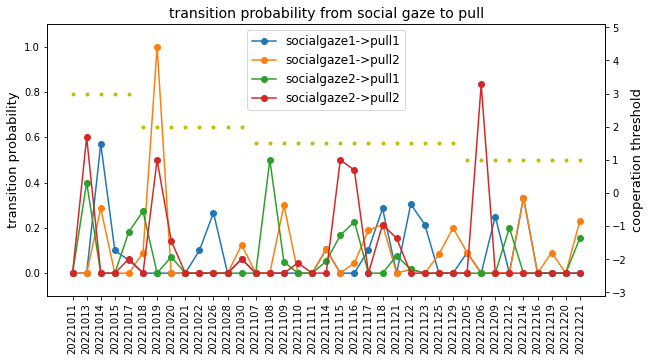

In [36]:
fig, ax1 = plt.subplots(figsize=(10, 5))
#
ax1.plot(DAGs_all_dates[:,2,0],'o-',label = "socialgaze1->pull1")
ax1.plot(DAGs_all_dates[:,2,1],'o-',label = "socialgaze1->pull2")
ax1.plot(DAGs_all_dates[:,3,0],'o-',label = "socialgaze2->pull1")
ax1.plot(DAGs_all_dates[:,3,1],'o-',label = "socialgaze2->pull2")
ax1.legend(fontsize=12)
ax1.set_ylim(-0.1,1.1)
ax1.set_ylabel("transition probability",fontsize=13)
#
plt.xticks(np.arange(0,ndates,1),dates_list, rotation=90,fontsize=10)
plt.yticks(fontsize=10)
plt.title("transition probability from social gaze to pull", fontsize = 14)
#
ax2 = ax1.twinx()
ax2.plot(coopthres_all_dates,'y.')
ax2.set_ylim(-3.1,5.1)
ax2.set_ylabel("cooperation threshold",fontsize=13)
#
plt.show()

### plot the transition probability from pull to social gaze

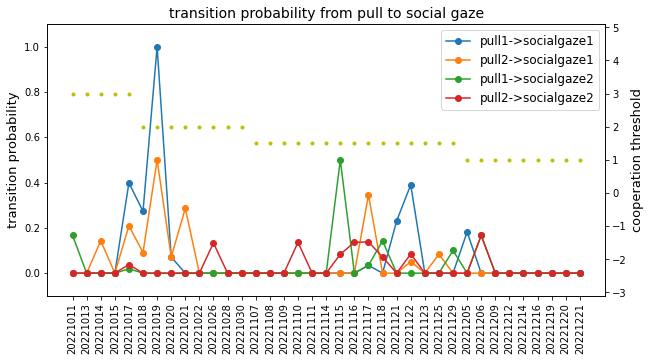

In [37]:
fig, ax1 = plt.subplots(figsize=(10, 5))
#
ax1.plot(DAGs_all_dates[:,0,2],'o-',label = "pull1->socialgaze1")
ax1.plot(DAGs_all_dates[:,1,2],'o-',label = "pull2->socialgaze1")
ax1.plot(DAGs_all_dates[:,0,3],'o-',label = "pull1->socialgaze2")
ax1.plot(DAGs_all_dates[:,1,3],'o-',label = "pull2->socialgaze2")
ax1.legend(fontsize=12)
ax1.set_ylim(-0.1,1.1)
ax1.set_ylabel("transition probability",fontsize=13)
#
plt.xticks(np.arange(0,ndates,1),dates_list, rotation=90,fontsize=10)
plt.yticks(fontsize=10)
plt.title("transition probability from pull to social gaze", fontsize = 14)
#
ax2 = ax1.twinx()
ax2.plot(coopthres_all_dates,'y.')
ax2.set_ylim(-3.1,5.1)
ax2.set_ylabel("cooperation threshold",fontsize=13)
#
plt.show()

### plot the transition probability from pull to pull

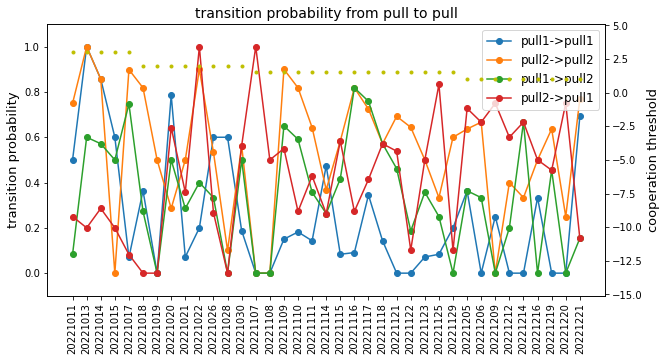

In [38]:
fig, ax1 = plt.subplots(figsize=(10, 5))
#
ax1.plot(DAGs_all_dates[:,0,0],'o-',label = "pull1->pull1")
ax1.plot(DAGs_all_dates[:,1,1],'o-',label = "pull2->pull2")
ax1.plot(DAGs_all_dates[:,0,1],'o-',label = "pull1->pull2")
ax1.plot(DAGs_all_dates[:,1,0],'o-',label = "pull2->pull1")
ax1.legend(fontsize=12)
ax1.set_ylim(-0.1,1.1)
ax1.set_ylabel("transition probability",fontsize=13)
#
plt.xticks(np.arange(0,ndates,1),dates_list, rotation=90,fontsize=10)
plt.yticks(fontsize=10)
plt.title("transition probability from pull to pull", fontsize = 14)
#
ax2 = ax1.twinx()
ax2.plot(coopthres_all_dates,'y.')
ax2.set_ylim(-15.1,5.1)
ax2.set_ylabel("cooperation threshold",fontsize=13)
#
plt.show()

### plot the transition probability from social gaze to social gaze

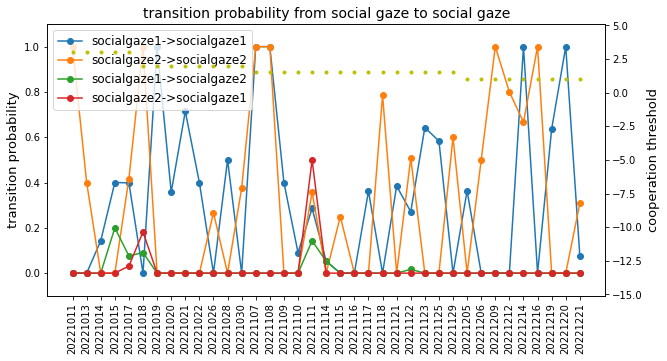

In [39]:
fig, ax1 = plt.subplots(figsize=(10, 5))
#
ax1.plot(DAGs_all_dates[:,2,2],'o-',label = "socialgaze1->socialgaze1")
ax1.plot(DAGs_all_dates[:,3,3],'o-',label = "socialgaze2->socialgaze2")
ax1.plot(DAGs_all_dates[:,2,3],'o-',label = "socialgaze1->socialgaze2")
ax1.plot(DAGs_all_dates[:,3,2],'o-',label = "socialgaze2->socialgaze1")
ax1.legend(fontsize=12)
ax1.set_ylim(-0.1,1.1)
ax1.set_ylabel("transition probability",fontsize=13)
#
plt.xticks(np.arange(0,ndates,1),dates_list, rotation=90,fontsize=10)
plt.yticks(fontsize=10)
plt.title("transition probability from social gaze to social gaze", fontsize = 14)
#
ax2 = ax1.twinx()
ax2.plot(coopthres_all_dates,'y.')
ax2.set_ylim(-15.1,5.1)
ax2.set_ylabel("cooperation threshold",fontsize=13)
#
plt.show()